# DCBC model evaluation

In [1]:

import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.functional_profiles as fp
import Functional_Fusion.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from scipy import stats
import glob
import numpy as np
import os



In [2]:
# Import symmetric evaluation
Sym = pd.read_csv(
    f'{ut.model_dir}/Models/Evaluation/eval_dataset7_sym.tsv', sep='\t')
Sym['symmetry'] = 'Symmetric'
Sym['train_data_string'] = Sym['train_data']
Sym['train_data'] = Sym['train_data'].apply(lambda x: x.split("' '"))


# Import asymmetric evaluation
Asym = pd.read_csv(
    f'{ut.model_dir}/Models/Evaluation/eval_dataset7_asym-hem.tsv', sep='\t')
Asym['symmetry'] = 'Asymmetric'

# Remove non-crossvalidated tests
Asym['train_data_string'] = Asym['train_data']
Asym['train_data'] = Asym['train_data'].apply(lambda x: x.split("', '"))
# Remove brackets and quotation marks from train_data
for i, row in Asym.iterrows():
    for j, train_data in enumerate(row['train_data']):
        train_data = train_data.replace('[', '')
        train_data = train_data.replace(']', '')
        train_data = train_data.replace("'", '')
        Asym.at[i, 'train_data'][j] = train_data

for i, row in Asym.iterrows():
    if row['test_data'] in row['train_data'] and not len(row['train_data']) == 7:
        Asym.drop(i, inplace=True)



In [3]:
Data = pd.concat([Sym, Asym], axis=0)
# Data = pd.concat([Data, Sym_add], axis=0)

# Loop through rows and add indicator for those where train_data list is of length 6
Data['train_data_len'] = Data['train_data'].apply(lambda x: len(x))
# Make Training column 'Single' if train_data_len is 1, 'All' if train_data_len is 7 and 'Leave_one_out' if train_data_len is 6
Data['Training'] = Data['train_data_len'].apply(
    lambda x: 'Single' if x == 1 else 'Leave_one_out')
Data.loc[Data['train_data_len'] == 7, 'Training'] = 'All'
Data.loc[Data['train_data_len'] == 6, 'train_data_string'] = 'Leave_one_out'
Data.loc[Data['train_data_len'] == 7, 'train_data_string'] = 'All'

# Show How many leave_one_out each K and each symmetry has
# Drop K=100
Data[Data['K'] != 100].groupby(
    ['symmetry', 'K', 'Training']).count()['test_data']


Data[(Data['K'] == 10) & (Data['model_name'] == 'sym_MdPoIbWmDeSo')].groupby(
    ['symmetry', 'atlas', 'model_name', 'Training', 'test_data', 'common_kappa', 'model_type']).count()

# Remove model_type 04 and K=100
Data = Data[(Data['model_type'] == 'Models_03') & (Data['K'] != 100)]
# Show pretty
# Data[(Data['K'] == 10) & (Data['model_name'] == 'sym_MdPoIbWmDeSo')]


In [4]:
# Define colours
sb.color_palette(sb.color_palette("tab10"))
# Get the first three colors in the "tab10" color palette
colors = sb.color_palette("tab10", n_colors=3)
hex_codes_single = [
    f"#{int(r * 255):02x}{int(g * 255):02x}{int(b * 255):02x}" for r, g, b in colors]
# Repeat colours to get 6 colours
hex_codes = np.repeat(hex_codes_single, 2)

<Figure size 1000x2000 with 0 Axes>

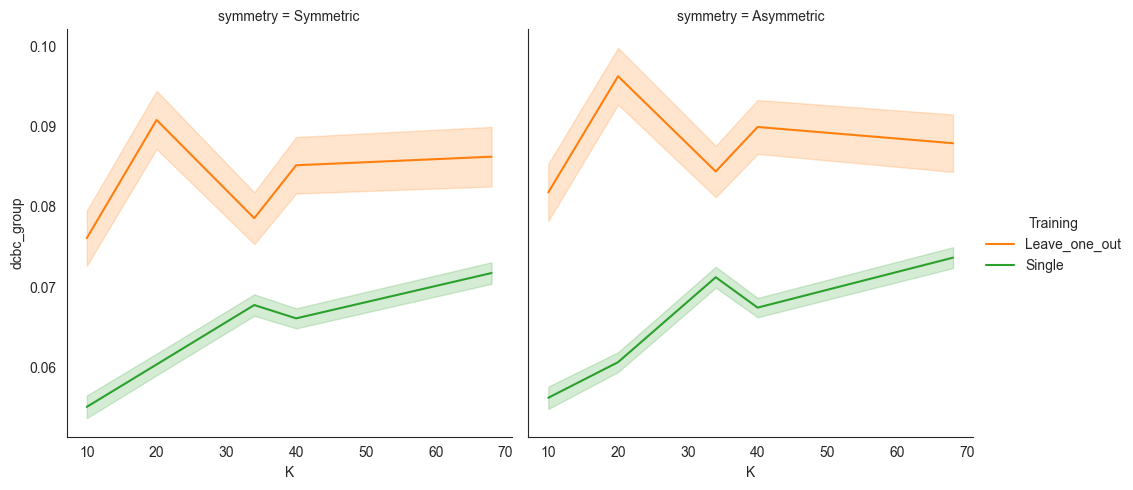

<Figure size 1000x2000 with 0 Axes>

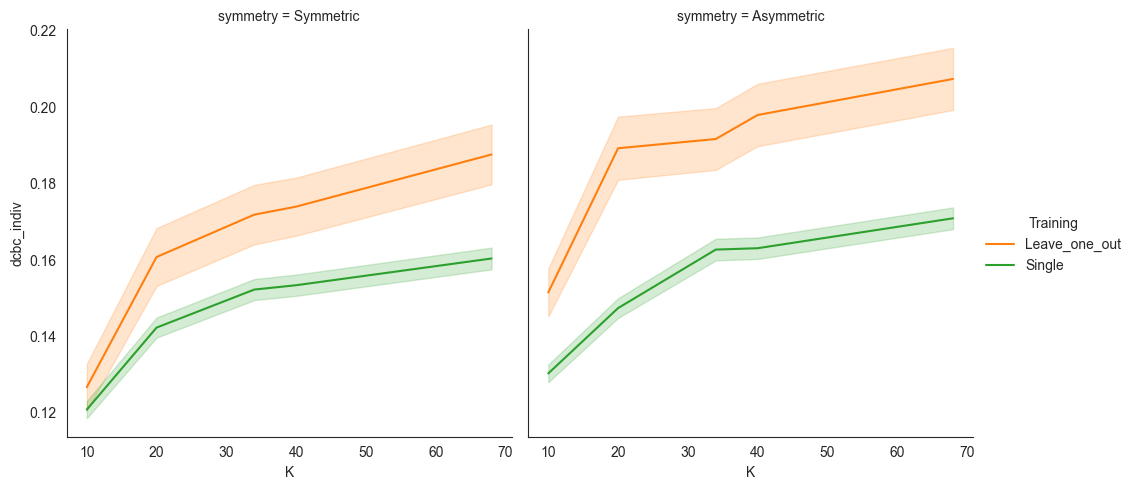

In [5]:
# Plot only cross-validated DCBC results

figsize = (10, 20)
plt.figure(figsize=figsize)
sb.set_style("white")
sb.relplot(
    data=Data[Data['K'].isin([10, 20, 34, 40, 68])], x="K", y="dcbc_group", hue="Training", kind="line", col="symmetry", markers=True, errorbar="se", hue_order = ['Leave_one_out', 'Single'], palette = hex_codes_single[1:])
plt.savefig(f'{ut.figure_dir}/DCBC_group.pdf')

figsize = (10, 20)
plt.figure(figsize=figsize)
sb.set_style("white")
sb.relplot(
    data=Data[Data['K'].isin([10, 20, 34, 40, 68])], x="K", y="dcbc_indiv", hue="Training", kind="line", col="symmetry", markers=True, errorbar="se", hue_order = ['Leave_one_out', 'Single'], palette = hex_codes_single[1:])
plt.savefig(f'{ut.figure_dir}/DCBC_individ.pdf')



# Group DCBC and Individual DCBC in one plot for Fusion atlas

In [6]:
# Melt Data
Data_melted = pd.melt(Data[Data['Training']=='Leave_one_out'], id_vars=['K', 'Training', 'symmetry'], value_vars=['dcbc_group', 'dcbc_indiv'], var_name='dcbc_type', value_name='DCBC')
Data_melted.head()

,K,Training,symmetry,dcbc_type,DCBC
0,10,Leave_one_out,Symmetric,dcbc_group,0.038595
1,10,Leave_one_out,Symmetric,dcbc_group,0.012023
2,10,Leave_one_out,Symmetric,dcbc_group,-0.009863
3,10,Leave_one_out,Symmetric,dcbc_group,0.108692
4,10,Leave_one_out,Symmetric,dcbc_group,0.120695


In [7]:
fusion_orange = '#ff7f0e'
fusion_orange = list(np.repeat(fusion_orange,2))

<Figure size 1000x2000 with 0 Axes>

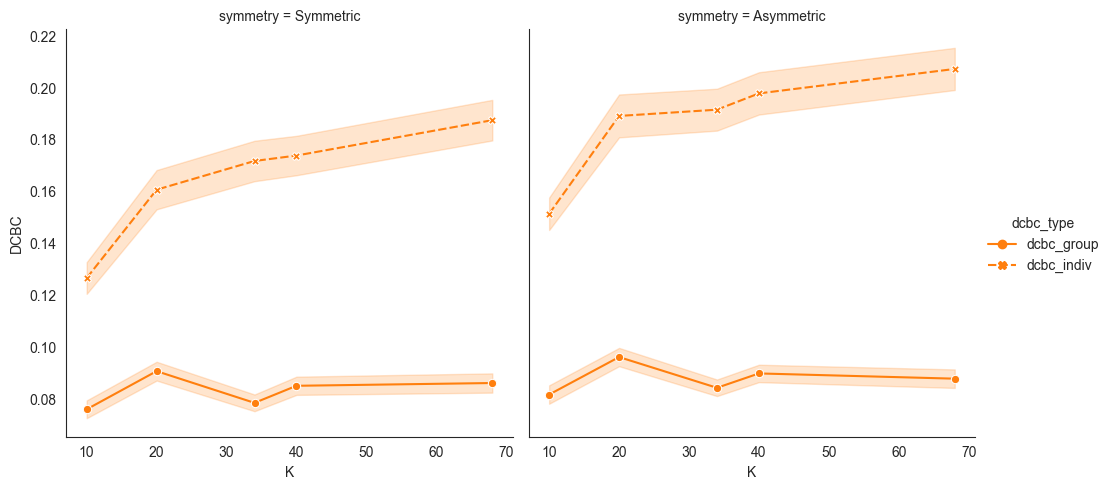

In [8]:
# Plot only fused DCBC results
hex_codes_fusion = np.repeat(hex_codes_single[1:], 4)
figsize = (10, 20)
plt.figure(figsize=figsize)
sb.set_style("white")
sb.relplot(
    data=Data_melted[Data_melted['K'].isin([10, 20, 34, 40, 68])], x="K", y="DCBC", hue="dcbc_type", kind="line", col="symmetry", markers=True, errorbar="se", palette = fusion_orange, style="dcbc_type")
plt.savefig(f'{ut.figure_dir}/DCBC_group_indiv.pdf')


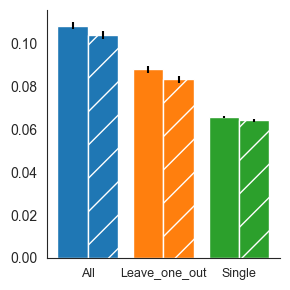

In [9]:
figsize = (3, 3)

# Bar graph at K=68 with hue = Symmetry where hue bars are next to each other
# Define the data
categories = Data[Data['K'].isin([10, 20, 34, 40, 68])].Training.unique()
hues = Data[Data['K'].isin([10, 20, 34, 40, 68])].symmetry.unique()

# Calculate the mean values for each category and hue combination
mean_values = Data[Data['K'].isin([10, 20, 34, 40, 68])].groupby(['Training', 'symmetry'])[
    'dcbc_group'].mean().values

# Calculate the standard error of the mean for each category and hue combination
sem_values = Data[Data['K'].isin([10, 20, 34, 40, 68])].groupby(['Training', 'symmetry'])[
    'dcbc_group'].sem().values

# Define the colors for each category
colors = sb.color_palette("tab10", n_colors=len(categories))

# Create a figure and axis
fig, ax = plt.subplots(figsize=figsize)

# Iterate over each category
for i, category in enumerate(categories):
    # Get the color for the current category
    color = colors[i]

    # Plot the bars for the two hues
    j = 2 * i
    ax.bar([i - 0.2, i + 0.2], mean_values[j:j + len(hues)], width=0.4,
           yerr=sem_values[j:j + len(hues)],
           color=color, label=hues)
    
    # Set a different hatch for every second bar
    ax.patches[j+1].set_hatch('/')

# Set the x-axis tick labels
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories)
# Smaller xtick labels  
ax.tick_params(axis='x', which='major', labelsize=9)

# plt.legend()
# Tight layout and despine
fig.tight_layout()
sb.despine()
# Export the plot at high resolution
plt.savefig(f'{ut.figure_dir}/DCBC_group_bar_avg.pdf', dpi=300)


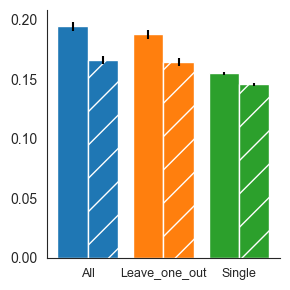

In [123]:
# Bar graph at K=68 with hue = Symmetry where hue bars are next to each other
sb.color_palette(sb.color_palette("tab10"))
# Get the first three colors in the "tab10" color palette
colors = sb.color_palette("tab10", n_colors=3)
hex_codes = [
    f"#{int(r * 255):02x}{int(g * 255):02x}{int(b * 255):02x}" for r, g, b in colors]
# Repeat colours to get 6 colours
hex_codes = np.repeat(hex_codes, 2)

# Define the data
categories = Data[Data['K'].isin([10, 20, 34, 40, 68])].Training.unique()
hues = Data[Data['K'].isin([10, 20, 34, 40, 68])].symmetry.unique()

# Calculate the mean values for each category and hue combination
mean_values = Data[Data['K'].isin([10, 20, 34, 40, 68])].groupby(['Training', 'symmetry'])[
    'dcbc_indiv'].mean().values

# Calculate the standard error of the mean for each category and hue combination
sem_values = Data[Data['K'].isin([10, 20, 34, 40, 68])].groupby(['Training', 'symmetry'])[
    'dcbc_indiv'].sem().values

# Define the colors for each category
colors = sb.color_palette("tab10", n_colors=len(categories))

# Create a figure and axis
fig, ax = plt.subplots(figsize=figsize)

# Iterate over each category
for i, category in enumerate(categories):
    # Get the color for the current category
    color = colors[i]

    # Plot the bars for the two hues
    j = 2 * i
    ax.bar([i - 0.2, i + 0.2], mean_values[j:j + len(hues)], width=0.4,
           yerr=sem_values[j:j + len(hues)],
           color=color, label=hues)

    # Set a different hatch for every second bar
    ax.patches[j + 1].set_hatch('/')

# Set the x-axis tick labels
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories)
# Smaller xtick labels
ax.tick_params(axis='x', which='major', labelsize=9)

# plt.legend()
# Tight layout and despine
fig.tight_layout()
sb.despine()
# Export the plot at high resolution
plt.savefig(f'{ut.figure_dir}/DCBC_group_bar_individual_avg.pdf', dpi=300)


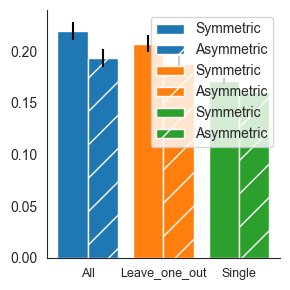

In [8]:
# Bar graph at K=68 with hue = Symmetry where hue bars are next to each other
sb.color_palette(sb.color_palette("tab10"))
# Get the first three colors in the "tab10" color palette
colors = sb.color_palette("tab10", n_colors=3)
hex_codes = [
    f"#{int(r * 255):02x}{int(g * 255):02x}{int(b * 255):02x}" for r, g, b in colors]
# Repeat colours to get 6 colours
hex_codes = np.repeat(hex_codes, 2)

# Define the data
categories = Data[Data['K'] == 68].Training.unique()
hues = Data[Data['K'] == 68].symmetry.unique()

# Calculate the mean values for each category and hue combination
mean_values = Data[Data['K'] == 68].groupby(['Training', 'symmetry'])[
    'dcbc_indiv'].mean().values

# Calculate the standard error of the mean for each category and hue combination
sem_values = Data[Data['K'] == 68].groupby(['Training', 'symmetry'])[
    'dcbc_indiv'].sem().values

# Define the colors for each category
colors = sb.color_palette("tab10", n_colors=len(categories))

# Create a figure and axis
fig, ax = plt.subplots(figsize=figsize)

# Iterate over each category
for i, category in enumerate(categories):
    # Get the color for the current category
    color = colors[i]

    # Plot the bars for the two hues
    j = 2 * i
    ax.bar([i - 0.2, i + 0.2], mean_values[j:j + len(hues)], width=0.4,
           yerr=sem_values[j:j + len(hues)],
           color=color, label=hues)

    # Set a different hatch for every second bar
    ax.patches[j + 1].set_hatch('/')

# Set the x-axis tick labels
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories)
# Smaller xtick labels
ax.tick_params(axis='x', which='major', labelsize=9)

plt.legend()
# Tight layout and despine
fig.tight_layout()
sb.despine()
# Export the plot at high resolution
plt.savefig(f'{ut.figure_dir}/DCBC_group_bar_individual_legend.pdf', dpi=300)


# Stats

In [10]:
# Add subject variables
datasets = Data['test_data'].unique()
Data['participant_id'] = ''
for dset in datasets:
    # Import participant info
    dataset = ds.get_dataset_class(ut.base_dir, dset)
    participants = dataset.get_participants().participant_id.tolist()
    participants = [dset + '_' + p for p in participants]
    select_rows = (Data['test_data'] == dset)
    Data['participant_id'][select_rows] = participants*int(len(select_rows)/len(participants))



/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_59580/2081741850.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['participant_id'][select_rows] = participants*int(len(select_rows)/len(participants))
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_59580/2081741850.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['participant_id'][select_rows] = participants*int(len(select_rows)/len(participants))
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_59580/2081741850.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

In [11]:
# -- Get average across two halves within each subject for each model, K and symmetry
# Step 1: Group the data by subject
grouped_data = Data.groupby(['participant_id', 'model_name', 'K', 'symmetry', 'Training'])
# Step 2: Calculate the average for each subject
averaged_data = grouped_data['dcbc_indiv', 'dcbc_group'].mean()
# Step 3: Create a new DataFrame with one row per subject and the averaged value
Data = averaged_data.reset_index()


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_59580/3368830371.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  averaged_data = grouped_data['dcbc_indiv', 'dcbc_group'].mean()


In [12]:
# Step 1: Group the data for single dataset parcellations by subject
grouped_data = Data[Data['Training']=='Single'].groupby(['participant_id', 'K', 'symmetry'])
# Step 2: Get the highest/average value for each subject
averaged_data = grouped_data['dcbc_indiv', 'dcbc_group'].mean() # .max() for highest value
# Step 3: Create a new DataFrame with one row per subject and the highest value
Data_single = averaged_data.reset_index()


# Step 1: Group the data for fusion parcellations by subject
grouped_data = Data[Data['Training']=='Leave_one_out'].groupby(['participant_id', 'K', 'symmetry'])
# Step 2: Get the mean value for each subject
Data_fusion = grouped_data['dcbc_indiv', 'dcbc_group'].mean().reset_index()



/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_59580/3358067484.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  averaged_data = grouped_data['dcbc_indiv', 'dcbc_group'].mean() # .max() for highest value
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_59580/3358067484.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  Data_fusion = grouped_data['dcbc_indiv', 'dcbc_group'].mean().reset_index()


# Fused vs. Best single dataset: Group DCBC

In [13]:
# -- Test averaged across all Ks -- #
# Single vs cross-validated Fused
dat1 = Data_single[(Data_single['symmetry'] == 'Symmetric')  & Data_single['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()
dat2 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & Data_fusion['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()
res = stats.ttest_rel(dat1['dcbc_group'], dat2['dcbc_group'])
# show degrees of freedom
df = len(dat1) - 1
# Show in scientific notation
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3e}, df = {df}')


# -- Test for K=68 only -- #
# Single vs cross-validated Fused
dat1 = Data_single[(Data_single['symmetry'] == 'Symmetric')  & (Data_single['K'] == 68) ]
dat2 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & (Data_fusion['K'] == 68) ]
res = stats.ttest_rel(dat1['dcbc_group'], dat2['dcbc_group'])
df = len(dat1) - 1
# Show in scientific notation
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3e}, df = {df}')


T = -4.466, p = 1.936e-05, df = 110
T = -2.820, p = 5.697e-03, df = 110


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_59580/2676486561.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dat1 = Data_single[(Data_single['symmetry'] == 'Symmetric')  & Data_single['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_59580/2676486561.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dat2 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & Data_fusion['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()


# Fused vs. Best single dataset: Individual DCBC

In [14]:
# -- Test averaged across all Ks -- #
# Single vs cross-validated Fused
dat1 = Data_single[(Data_single['symmetry'] == 'Symmetric')  & Data_single['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()
dat2 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & Data_fusion['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()
res = stats.ttest_rel(dat1['dcbc_indiv'], dat2['dcbc_indiv'])
# show degrees of freedom
df = len(dat1) - 1
# Show in scientific notation
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3e}, df = {df}')
# Show in normal notation
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3f}, df = {df}')

# -- Test for K=68 only -- #
# Single vs cross-validated Fused
dat1 = Data_single[(Data_single['symmetry'] == 'Symmetric')  & (Data_single['K'] == 68) ]
dat2 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & (Data_fusion['K'] == 68) ]
res = stats.ttest_rel(dat1['dcbc_indiv'], dat2['dcbc_indiv'])
df = len(dat1) - 1
# Show in scientific notation
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3e}, df = {df}')
# Show in normal notation
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3f}, df = {df}')


T = -2.564, p = 1.171e-02, df = 110
T = -2.564, p = 0.012, df = 110
T = -3.586, p = 5.018e-04, df = 110
T = -3.586, p = 0.001, df = 110


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_59580/333086501.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dat1 = Data_single[(Data_single['symmetry'] == 'Symmetric')  & Data_single['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_59580/333086501.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dat2 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & Data_fusion['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()


# Symmetric vs Asymmetric: Group DCBC

In [24]:
# -- Test for K=68 only : Symmetric vs Asymmetric 
# Fused atlas symmetric vs Fused atlas asymmetric 
dat1 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & (Data_fusion['K'] == 68) ]
dat2 = Data_fusion[(Data_fusion['symmetry'] == 'Asymmetric')  & (Data_fusion['K'] == 68) ]
res = stats.ttest_rel(dat1['dcbc_group'], dat2['dcbc_group'])
df = len(dat1) - 1
# Show in scientific notation
print(f'\nFusion symmetric vs Fusion asymmetric at 68')
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3e}, df = {df}')
# Show in normal notation
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3f}, df = {df}')

# -- Averaged across Ks:
dat1 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & Data_fusion['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()
dat2 = Data_fusion[(Data_fusion['symmetry'] == 'Asymmetric')  & Data_fusion['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()
res = stats.ttest_rel(dat1['dcbc_group'], dat2['dcbc_group'])
# show degrees of freedom
df = len(dat1) - 1
# Show in scientific notation
print(f'\nFusion symmetric vs Fusion asymmetric')
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3e}, df = {df}')
# Show in normal notation
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3f}, df = {df}')


# -- Averaged across Ks:
dat1 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & Data_fusion['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()
dat2 = Data_single[(Data_single['symmetry'] == 'Asymmetric')  & Data_single['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()
res = stats.ttest_rel(dat1['dcbc_group'], dat2['dcbc_group'])
# show degrees of freedom
df = len(dat1) - 1
# Show in scientific notation
print(f'\nFusion symmetric vs Single asymmetric')
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3e}, df = {df}')
# Show in normal notation
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3f}, df = {df}')

# Symmetric fused atlas vs Asymmetric single dataset atlas cross-validated
dat1 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & (Data_fusion['K'] == 68) ]
dat2 = Data_single[(Data_single['symmetry'] == 'Asymmetric')  & (Data_single['K'] == 68) ]
res = stats.ttest_rel(dat1['dcbc_group'], dat2['dcbc_group'])
df = len(dat1) - 1
# Show in scientific notation
print(f'\nFusion symmetric vs Single asymmetric at K68')
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3e}, df = {df}')

# --> No significant difference between asymmetric and symmetric in group dcbc! 


Fusion symmetric vs Fusion asymmetric at 68
T = -0.660, p = 5.108e-01, df = 110
T = -0.660, p = 0.511, df = 110

Fusion symmetric vs Fusion asymmetric
T = -2.344, p = 2.089e-02, df = 110
T = -2.344, p = 0.021, df = 110

Fusion symmetric vs Single asymmetric
T = 4.855, p = 4.009e-06, df = 110
T = 4.855, p = 0.000, df = 110

Fusion symmetric vs Single asymmetric at K68
T = 2.788, p = 6.249e-03, df = 110


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_59580/379277659.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dat1 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & Data_fusion['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_59580/379277659.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dat2 = Data_fusion[(Data_fusion['symmetry'] == 'Asymmetric')  & Data_fusion['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_59580/379277

# Symmetric vs Asymmetric: Individual DCBC

In [26]:
# -- Test for K=68 only : Symmetric vs Asymmetric 
# Fused atlas symmetric vs Fused atlas asymmetric 
dat1 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & (Data_fusion['K'] == 68) ]
dat2 = Data_fusion[(Data_fusion['symmetry'] == 'Asymmetric')  & (Data_fusion['K'] == 68) ]
res = stats.ttest_rel(dat1['dcbc_indiv'], dat2['dcbc_indiv'])
df = len(dat1) - 1
# Show in scientific notation
print(f'\nFusion symmetric vs Fusion asymmetric at K=68')
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3e}, df = {df}')
# Show in normal notation
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3f}, df = {df}')


# -- Averaged across Ks:
dat1 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & Data_fusion['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()
dat2 = Data_fusion[(Data_fusion['symmetry'] == 'Asymmetric')  & Data_fusion['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()
res = stats.ttest_rel(dat1['dcbc_indiv'], dat2['dcbc_indiv'])
# show degrees of freedom
df = len(dat1) - 1
# Show in scientific notation
print(f'\nFusion symmetric vs Fusion asymmetric')
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3e}, df = {df}')
# Show in normal notation
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3f}, df = {df}')

# -- Averaged across Ks:
dat1 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & Data_fusion['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()
dat2 = Data_single[(Data_single['symmetry'] == 'Asymmetric')  & Data_single['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()
res = stats.ttest_rel(dat1['dcbc_indiv'], dat2['dcbc_indiv'])
# show degrees of freedom
df = len(dat1) - 1
# Show in scientific notation
print(f'\nFusion symmetric vs Single asymmetric')
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3e}, df = {df}')
# Show in normal notation
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3f}, df = {df}')


# Symmetric fused atlas vs Asymmetric single dataset atlas cross-validated
dat1 = Data_single[(Data_single['symmetry'] == 'Asymmetric')  & (Data_single['K'] == 68) ]
dat2 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & (Data_fusion['K'] == 68) ]
res = stats.ttest_rel(dat1['dcbc_indiv'], dat2['dcbc_indiv'])
df = len(dat1) - 1
# Show in scientific notation
print(f'\nFusion symmetric vs Single asymmetric at K=68')
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3e}, df = {df}')

# --> No significant difference between asymmetric and symmetric in group dcbc! 


Fusion symmetric vs Fusion asymmetric at K=68
T = -4.081, p = 8.510e-05, df = 110
T = -4.081, p = 0.000, df = 110

Fusion symmetric vs Fusion asymmetric
T = -5.023, p = 1.981e-06, df = 110
T = -5.023, p = 0.000, df = 110

Fusion symmetric vs Single asymmetric
T = 1.662, p = 9.936e-02, df = 110
T = 1.662, p = 0.099, df = 110

Fusion symmetric vs Single asymmetric at K=68
T = -2.842, p = 5.338e-03, df = 110


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_59580/1133643994.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dat1 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & Data_fusion['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_59580/1133643994.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dat2 = Data_fusion[(Data_fusion['symmetry'] == 'Asymmetric')  & Data_fusion['K'].isin([10, 20, 34, 40, 68])].groupby(['participant_id']).mean()
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_59580/1133

# Granularity: Does K=68 perform better than K=40 in the individual? Is there a difference between K=20 and K=68 in the group?

In [111]:

# -- Group DCBC 68 vs 20 -- #
# Single vs cross-validated Fused
dat1 = Data_fusion[(Data_single['symmetry'] == 'Symmetric')  & (Data_single['K'] == 68) ]
dat2 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & (Data_fusion['K'] == 20) ]
res = stats.ttest_rel(dat1['dcbc_group'], dat2['dcbc_group'])
df = len(dat1) - 1
# Show in scientific notation
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3e}, df = {df}')
# Show in normal notation
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3f}, df = {df}')



# -- Group DCBC 68 vs 10 -- #
# Single vs cross-validated Fused
dat1 = Data_fusion[(Data_single['symmetry'] == 'Symmetric')  & (Data_single['K'] == 68) ]
dat2 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & (Data_fusion['K'] == 10) ]
res = stats.ttest_rel(dat1['dcbc_group'], dat2['dcbc_group'])
df = len(dat1) - 1
# Show in scientific notation
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3e}, df = {df}')
# Show in normal notation
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3f}, df = {df}')


# -- Individual DCBC 68 vs 40 -- #
# Single vs cross-validated Fused
dat1 = Data_fusion[(Data_single['symmetry'] == 'Symmetric')  & (Data_single['K'] == 68) ]
dat2 = Data_fusion[(Data_fusion['symmetry'] == 'Symmetric')  & (Data_fusion['K'] == 40) ]
res = stats.ttest_rel(dat1['dcbc_indiv'], dat2['dcbc_indiv'])
df = len(dat1) - 1
# Show in scientific notation
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3e}, df = {df}')
# Show in normal notation
print(f'T = {res.statistic:.3f}, p = {res.pvalue:.3f}, df = {df}')

T = -1.580, p = 1.170e-01, df = 110
T = -1.580, p = 0.117, df = 110
T = 2.783, p = 6.345e-03, df = 110
T = 2.783, p = 0.006, df = 110
T = 7.584, p = 1.143e-11, df = 110
T = 7.584, p = 0.000, df = 110
